# **Clustering applied to audio embeddings without dimensionality reduction**

Métodos a usar:
- SVM
- XGBoost

Métricas de evaluación
- Accuracy
- Precision
- Recall
- F1 score

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBClassifier

In [2]:
def show_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average="weighted")
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="weighted")
    rec = recall_score(y_true, y_pred, average="weighted")

    print("F1 score: ", f1)
    print("Accuracy: ", acc)
    print("Precision: ", prec)
    print("Recall: ", rec)

In [15]:
def plot_confusion_matrix(y_true, y_pred, labels, title):
    mc = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)
    plt.figure(figsize=(7, 5))
    sns.heatmap(mc, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'{title} Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

### Load features

In [3]:
df_raw = pd.read_csv("D:/Documents-D/Downloads/emotion.csv")
df = df_raw.fillna(0)

In [4]:
X = df.iloc[: ,:-1].values
y = df['Emotions'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((38918, 2376), (38918,), (9730, 2376), (9730,))

In [6]:
labels_dict = {}
unique_labels = np.unique(y)
for i, label in enumerate(unique_labels):
    labels_dict[label] = i
y_train_num = np.array([labels_dict[elem] for elem in y_train])
y_test_num = np.array([labels_dict[elem] for elem in y_test])

In [21]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(knn, X_train, y_train, cv=kf, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())
print("Standard deviation of cross-validation scores:", cv_scores.std())

Cross-validation scores: [0.56988695 0.57515416 0.57798047 0.56854683 0.57368624]
Mean cross-validation score: 0.5730509309627976
Standard deviation of cross-validation scores: 0.0034474707280556165


In [17]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

show_metrics(y_test, knn_pred)

F1 score:  0.606241764494946
Accuracy:  0.6054470709146968
Precision:  0.6119961087020676
Recall:  0.6054470709146968


### SVM

In [22]:
svm = SVC(random_state=0, kernel='poly', degree=2)
svm.fit(X=X_train, y=y_train)
svm_pred = svm.predict(X_test)

show_metrics(y_true=y_test, y_pred=svm_pred)

F1 score:  0.5926814639481006
Accuracy:  0.5943473792394656
Precision:  0.6049015918868752
Recall:  0.5943473792394656


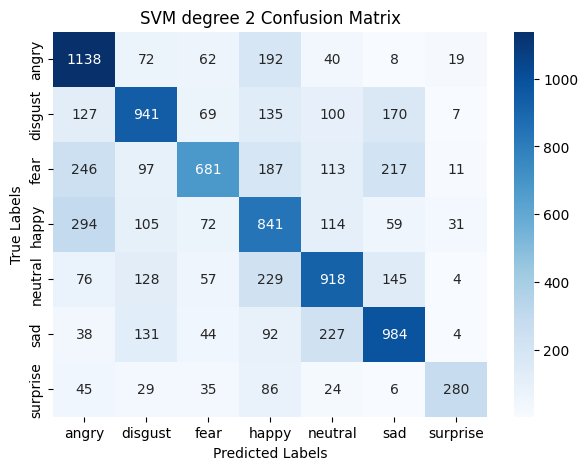

In [23]:
plot_confusion_matrix(y_true=y_test, y_pred=svm_pred, labels=unique_labels, title='SVM degree 2')

F1 score:  0.5869512160773809
Accuracy:  0.587667009249743
Precision:  0.6260423869561978
Recall:  0.587667009249743


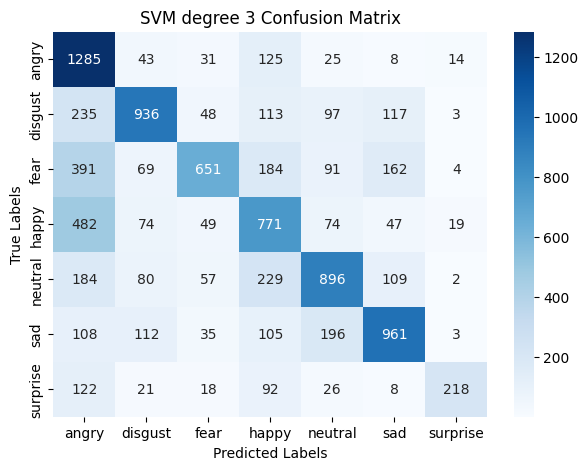

In [16]:
svm = SVC(random_state=0, kernel='poly', degree=3)
svm.fit(X=X_train, y=y_train)
svm_pred = svm.predict(X_test)

show_metrics(y_true=y_test, y_pred=svm_pred)
plot_confusion_matrix(y_true=y_test, y_pred=svm_pred, labels=unique_labels, title='SVM degree 3')

F1 score:  0.5997997713863565
Accuracy:  0.6023638232271326
Precision:  0.6062289165637268
Recall:  0.6023638232271326


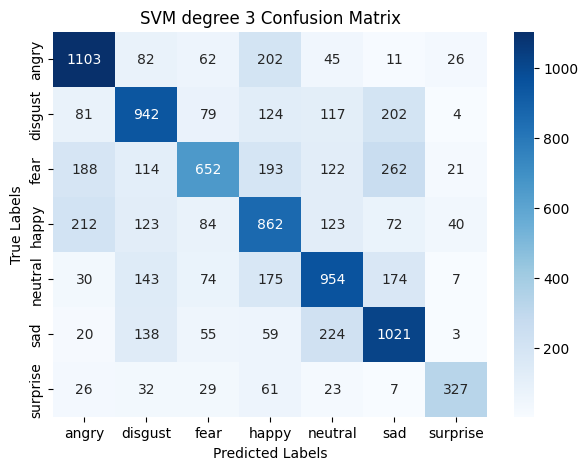

In [24]:
svm = SVC(random_state=0, kernel='rbf')
svm.fit(X=X_train, y=y_train)
svm_pred = svm.predict(X_test)

show_metrics(y_true=y_test, y_pred=svm_pred)
plot_confusion_matrix(y_true=y_test, y_pred=svm_pred, labels=unique_labels, title='SVM degree 3')
# rbf

### Decision Tree

Un árbol por sí solo es un estimador muy débil.

In [15]:
dt = DecisionTreeClassifier()
dt = dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

show_metrics(y_test, dt_pred)

F1 score:  0.4897263371892782
Accuracy:  0.4894141829393628
Precision:  0.49017442484418083
Recall:  0.4894141829393628


### XGBoost

Potenciar la estructura de árbol.

In [7]:
parameters = {
    'n_estimators':[64, 128, 256, 512],
    'max_depth': [8, 10],
    'learning_rate': [0.5, 1]
}

for params in ParameterGrid(parameters):
    try:
        bst = XGBClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'], learning_rate=params['learning_rate'], objective='multi:softmax') 
        bst.fit(X_train, y_train_num)
        pred_bst = bst.predict(X_test)

        pred_bst_ = [unique_labels[i] for i in pred_bst]
        print(params)
        show_metrics(y_true=y_test, y_pred=pred_bst_)
    except:
        print("Failed execution for ", params)
    print()

{'learning_rate': 0.5, 'max_depth': 8, 'n_estimators': 64}
F1 score:  0.7467910494937603
Accuracy:  0.7465570400822199
Precision:  0.749807771529095
Recall:  0.7465570400822199

{'learning_rate': 0.5, 'max_depth': 8, 'n_estimators': 128}
F1 score:  0.7935668270980278
Accuracy:  0.7935251798561151
Precision:  0.7956730957187587
Recall:  0.7935251798561151

{'learning_rate': 0.5, 'max_depth': 8, 'n_estimators': 256}
F1 score:  0.8207576811718507
Accuracy:  0.8207605344295992
Precision:  0.8226062108057318
Recall:  0.8207605344295992

{'learning_rate': 0.5, 'max_depth': 8, 'n_estimators': 512}
F1 score:  0.8289563245608231
Accuracy:  0.8289825282631038
Precision:  0.8304800411775016
Recall:  0.8289825282631038

{'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 64}
F1 score:  0.7731670553854738
Accuracy:  0.7730729701952723
Precision:  0.7748697044561198
Recall:  0.7730729701952723

{'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 128}
F1 score:  0.7975126260105287
Accuracy:  

In [8]:
bst = XGBClassifier(n_estimators=512, max_depth=8, learning_rate=0.5, objective='multi:softmax') 
bst.fit(X_train, y_train_num)
pred_bst = bst.predict(X_test)

pred_bst_ = [unique_labels[i] for i in pred_bst]
show_metrics(y_true=y_test, y_pred=pred_bst_)

F1 score:  0.8289563245608231
Accuracy:  0.8289825282631038
Precision:  0.8304800411775016
Recall:  0.8289825282631038


In [20]:
train_pred_bst = bst.predict(X_train)
train_pred_bst_ = [unique_labels[i] for i in train_pred_bst]
show_metrics(y_true=y_train, y_pred=train_pred_bst_)

F1 score:  0.9998458297764969
Accuracy:  0.9998458296932011
Precision:  0.9998458633994197
Recall:  0.9998458296932011


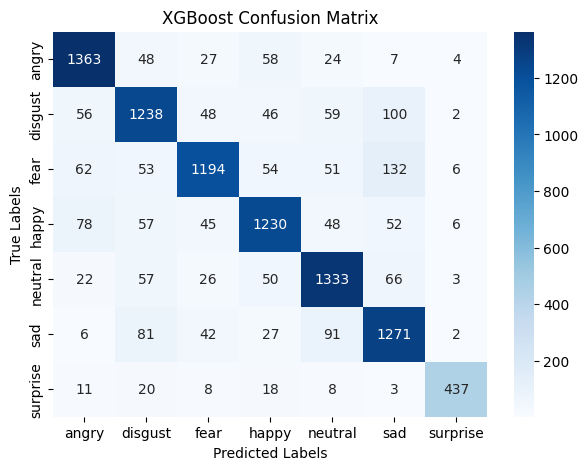

In [14]:
plot_confusion_matrix(y_true=y_test, y_pred=pred_bst_, labels=unique_labels, title='XGBoost')

In [10]:
class_accuracies = {}
for i, label in enumerate(unique_labels):
    true_positives = mc[i, i]
    total_instances = np.sum(mc[i, :])
    accuracy = true_positives / total_instances if total_instances > 0 else 0
    class_accuracies[label] = accuracy

# Print the results
for label, accuracy in class_accuracies.items():
    print(f"Accuracy for class '{label}': {accuracy:.2f}")

Accuracy for class 'angry': 0.89
Accuracy for class 'disgust': 0.80
Accuracy for class 'fear': 0.77
Accuracy for class 'happy': 0.81
Accuracy for class 'neutral': 0.86
Accuracy for class 'sad': 0.84
Accuracy for class 'surprise': 0.87
